# Solução do modelo de barganha de Dou et al. (2019)




In [1]:
#para mostrar todos os resultados e não apenas o último
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"


In [38]:
#libraries
import numpy as np
from numba import jit, jitclass, float64, njit
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from scipy.stats import beta

## Algoritmo

1. Sortear o credor que proporá neste turno, com chance $\lambda_j$

2. Fazer o credor sorteado escolher entre Liquidar ou Reorganizar a firma, de acordo com a sua equação de Bellman

4. Verificar se o credor adversário aceita ou rejeita:
    1. Se aceitar, os payoffs são realizados e o jogo acaba
    2. Se rejeitar, passamos para o próximo turno
    






In [58]:
#parâmetros iniciais


#número máximo de rodadas (em McCall era 'n')
T = 500


#parâmetros iniciais da distribuição beta

a, b =  1, 9                        # default parameters

#grid onde ela irá variar 
x = np.linspace(beta.ppf(0.01, a, b),
               beta.ppf(0.99, a, b), T)

F_default = beta.cdf(x, a, b)     # cdf distribuição Beta 


In [61]:
F_default

array([0.01      , 0.01711669, 0.02418787, 0.0312138 , 0.03819472,
       0.0451309 , 0.05202257, 0.05887   , 0.06567342, 0.0724331 ,
       0.07914926, 0.08582217, 0.09245206, 0.09903917, 0.10558376,
       0.11208605, 0.11854629, 0.12496471, 0.13134156, 0.13767706,
       0.14397146, 0.15022499, 0.15643787, 0.16261035, 0.16874264,
       0.17483499, 0.18088761, 0.18690074, 0.1928746 , 0.19880941,
       0.2047054 , 0.21056279, 0.21638181, 0.22216266, 0.22790558,
       0.23361078, 0.23927847, 0.24490887, 0.2505022 , 0.25605868,
       0.2615785 , 0.26706189, 0.27250906, 0.27792021, 0.28329555,
       0.2886353 , 0.29393965, 0.29920882, 0.30444301, 0.30964241,
       0.31480724, 0.31993769, 0.32503397, 0.33009628, 0.3351248 ,
       0.34011975, 0.34508131, 0.35000968, 0.35490507, 0.35976765,
       0.36459762, 0.36939517, 0.37416051, 0.3788938 , 0.38359525,
       0.38826503, 0.39290335, 0.39751037, 0.4020863 , 0.4066313 ,
       0.41114557, 0.41562928, 0.42008263, 0.42450578, 0.42889

## Gráfico da distribuição beta


<function matplotlib.pyplot.show(*args, **kw)>

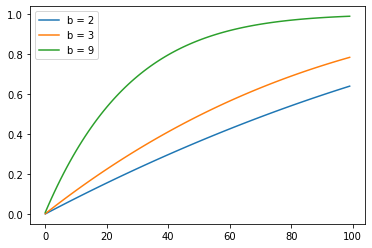

In [39]:
plt.plot(beta.cdf(x, a, b = 2), label = "b = " + str(2) )

plt.plot(beta.cdf(x, a, b = 3), label = "b = " + str(3))

plt.plot(beta.cdf(x, a, b = 9), label = "b = " + str(9))

plt.legend()
plt.show

In [133]:
#conjunto dos valores da firma
ρ = 0.9
v_min, v_max = 10, 100
v_default = np.linspace(v_max, v_min, T+1)

v_default

array([100.  ,  99.82,  99.64,  99.46,  99.28,  99.1 ,  98.92,  98.74,
        98.56,  98.38,  98.2 ,  98.02,  97.84,  97.66,  97.48,  97.3 ,
        97.12,  96.94,  96.76,  96.58,  96.4 ,  96.22,  96.04,  95.86,
        95.68,  95.5 ,  95.32,  95.14,  94.96,  94.78,  94.6 ,  94.42,
        94.24,  94.06,  93.88,  93.7 ,  93.52,  93.34,  93.16,  92.98,
        92.8 ,  92.62,  92.44,  92.26,  92.08,  91.9 ,  91.72,  91.54,
        91.36,  91.18,  91.  ,  90.82,  90.64,  90.46,  90.28,  90.1 ,
        89.92,  89.74,  89.56,  89.38,  89.2 ,  89.02,  88.84,  88.66,
        88.48,  88.3 ,  88.12,  87.94,  87.76,  87.58,  87.4 ,  87.22,
        87.04,  86.86,  86.68,  86.5 ,  86.32,  86.14,  85.96,  85.78,
        85.6 ,  85.42,  85.24,  85.06,  84.88,  84.7 ,  84.52,  84.34,
        84.16,  83.98,  83.8 ,  83.62,  83.44,  83.26,  83.08,  82.9 ,
        82.72,  82.54,  82.36,  82.18,  82.  ,  81.82,  81.64,  81.46,
        81.28,  81.1 ,  80.92,  80.74,  80.56,  80.38,  80.2 ,  80.02,
      

In [4]:
#código do modelo de McCall


@jitclass(dou_data)
class DouModel:

    def __init__(self, Ls=25, Lj=25,, β=9, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default
    def bellman(self, i, v):
        """
        The r.h.s. of the Bellman equation at state i.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate right hand side of Bellman equation
        max_value = max(w[i] / (1 - β), c + β * np.sum(v * q))
        return(max_value)

SyntaxError: invalid syntax (<ipython-input-4-412b4b79c109>, line 7)

## Sorteio do jogador no período t

In [132]:
#sorteio do jogador
λj = 0.3





#vamos criar uma variável para dizer se é a vez do jogador s ou j
#s[t] = 1 nos turnos em que s é chamado a jogar
U = np.random.uniform(0,1, size = T)
s = np.empty(T, dtype=np.int_)

for t in range(T):

    s[t] = λj < U[t]


#checando
sum(s)

500 * 0.7

341

350.0

## Bellman do jogador s

Vou chamar de Rs o valor de reorganização liderado por s.

Rs = Us - Ps, onde Ps é a proposta de pagamento feita por s

In [ ]:
## Bellman do jogador s


#Valor de reorganização da firma






Ws = (1-λj) * max(Ls, Rs)
    + λj * 
    + λj *